In [1]:
# user-friendly print
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
from joblib import Parallel, delayed

from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter, PercentFormatter
from collections import defaultdict
from crystallus import __version__, CrystalGenerator, WyckoffCfgGenerator
from crystallus.utils import WyckoffPositionConverter, build_structure, get_equivalent_coords, structure_dissimilarity 
from pymatgen import Structure
from pymatgen.analysis.structure_analyzer import SpacegroupAnalyzer

In [2]:
__version__

'0.3.0.dev'

## Test case: `Ag32Ge4S24`.

* Spacegroup 33
* Wyckoff positions:
    (x,y,z) (-x,-y,z+1/2) (x+1/2,-y+1/2,z) (-x+1/2,y+1/2,z+1/2)
* Ground truth:
    {Ag: 4a \* 8, Ge: 4a, S: 4a \* 5}

In [3]:
wg = WyckoffCfgGenerator(Ag=32, Ge=4, S=24)
wg

WyckoffCfgGenerator(            
    max_recurrent=1000,            
    n_jobs=-1            
    priority=None            
    composition={'Ag': 32, 'Ge': 4, 'S': 24}            
)

In [4]:
cfgs = wg.gen_many(1000, 33)
cfgs

[{'Ag': ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a'],
  'Ge': ['a'],
  'S': ['a', 'a', 'a', 'a', 'a', 'a']}]

Please note that space group 33 only has one Wyckoff position set.

In [5]:
cg = CrystalGenerator(
    spacegroup_num=33,
    estimated_volume=1168.454590,
    estimated_variance=15,
    verbose=False,
)
cg

CrystalGenerator(            
    spacegroup_num=33,            
    estimated_volume=1168.45459,            
    estimated_variance=15,            
    angle_range=(30.0, 150.0),            
    angle_tolerance=20.0,            
    max_attempts_number=5000,            
    empirical_coords=None,            
    empirical_coords_variance=0.01,            
    empirical_coords_sampling_rate=1.0,            
    verbose=False            
    n_jobs=-1            
)

### Test the most strict case

In [5]:
%%time

expect_size = 100_000_000
results = []
ret = cg.gen_many(expect_size, cfgs[0], distance_scale_factor=0)
len(ret)

CPU times: user 9h 3min 5s, sys: 2min 3s, total: 9h 5min 9s
Wall time: 20min 12s


0

### Calculate the `distance_scale_factor` dependency

In [6]:
%%time

expect_size = 500_000
results = []
radius = {"S": 1.02, "Ge": 1.18, "Ag": 1.4}
raw = np.array(
    [0.0, 0, 2.04, 2.20, 2.42, 2.36, 2.58, 2.8]
)

for d in np.linspace(0.2, 0.5, 16):
    ret = cg.gen_many(expect_size, cfgs[0], distance_scale_factor=d)
    ratio = len(ret) / expect_size
    raw_ = raw * (1 - d)
    raw_[0], raw_[1] = d, ratio
    results.append(raw_)

CPU times: user 43min 36s, sys: 9.24 s, total: 43min 45s
Wall time: 1min 41s


In [7]:
results = pd.DataFrame(results, columns=['scale', 'proportion', 'S-S', 'S-Ge', 'S-Ag', 'Ge-Ge', 'Ge-Ag', 'Ag-Ag'])
results.to_pickle('results.pd.xz')
results.head(3)

,scale,proportion,S-S,S-Ge,S-Ag,Ge-Ge,Ge-Ag,Ag-Ag
0,0.20,0.000000,1.6320,1.760,1.9360,1.8880,2.0640,2.240
1,0.22,0.000002,1.5912,1.716,1.8876,1.8408,2.0124,2.184
2,0.24,0.000000,1.5504,1.672,1.8392,1.7936,1.9608,2.128


(0.0, 2.5)

Text(0, 0.5, 'Tolerance for atomic distance')

Text(0.5, 0, 'Scale factor')

<BarContainer object of 16 artists>

Text(0, 0.5, 'Proportion of successes')

(0.19, 0.51)

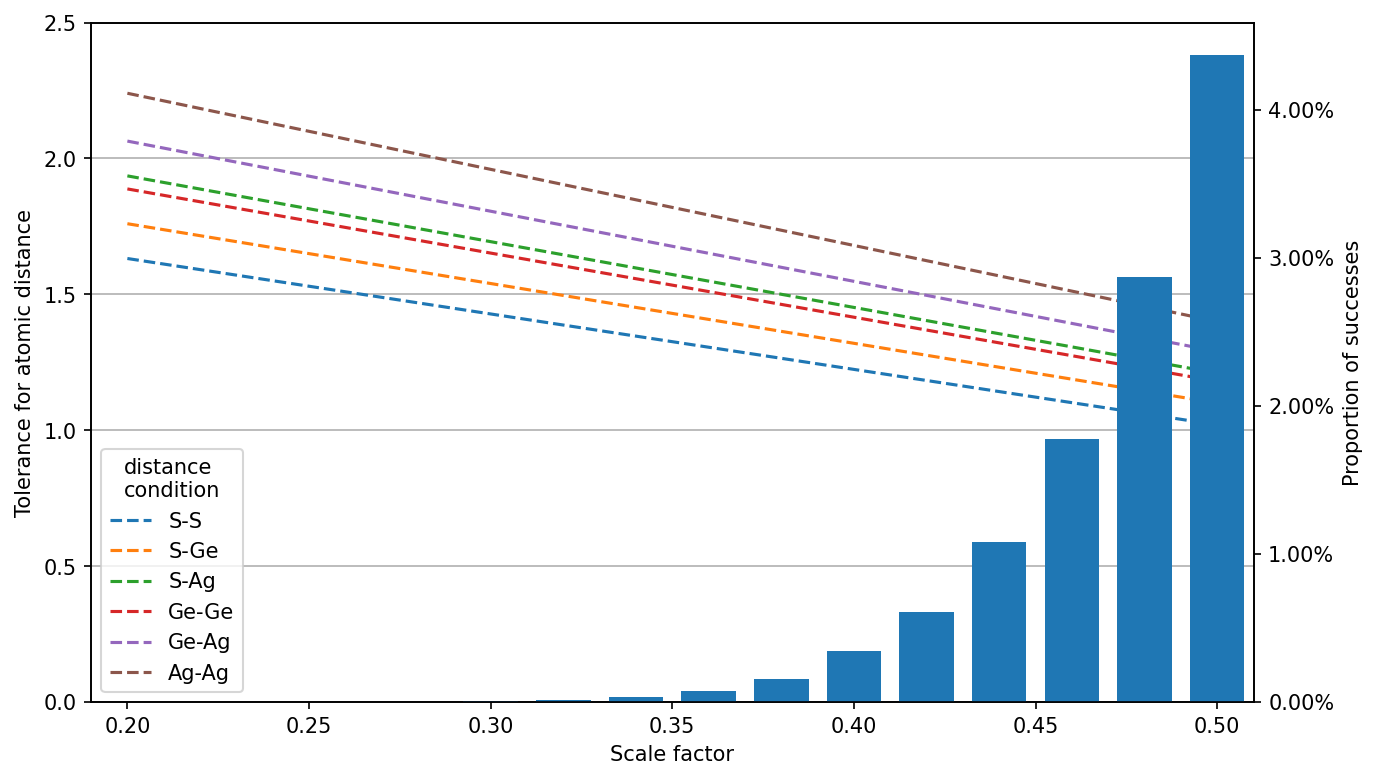

In [8]:
f, ax_tolerance = plt.subplots(figsize=(10, 6), dpi=150)

results.plot.line(x='scale', y=['S-S', 'S-Ge', 'S-Ag', 'Ge-Ge', 'Ge-Ag', 'Ag-Ag'], linestyle='dashed', ax=ax_tolerance)
ax_tolerance.set_ylim(0, 2.5)
ax_tolerance.set_ylabel('Tolerance for atomic distance')
ax_tolerance.set_xlabel('Scale factor')
ax_tolerance.legend(loc='lower left', title='distance\ncondition')
ax_tolerance.grid(axis='y')
ax_tolerance.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax_size= ax_tolerance.twinx()
ax_size.bar(results.scale, results.proportion, 0.015)
ax_size.yaxis.set_major_formatter(PercentFormatter(1))
ax_size.set_ylabel('Proportion of successes')
ax_size.set_xlim(0.19, 0.51)

# f.savefig('Ag32Ge4S24_generation_analysis.png', bbox_inches='tight', dpi=300)

From the result of `distance_scale_factor` dependency. Set the `distance_scale_factor` to `0.45` seems to be a good choice.

### Generation using empirical atomic coordinates

In [6]:
ag32ge4s24_like = pd.read_pickle('Ag32Ge4S24_like.pd.xz')
ag32ge4s24_like

,full_formula,composition,composition_ratio,total_atoms,elements,n_elements,space_group_num,space_group,wy_cfg,wy_reformat,wy_pattern,wy_pattern_loose,wy_unique,ss_cfg,ss_reformat,ss_pattern,ss_pattern_loose,ss_unique,volume_of_cell
id,,,,,,,,,,,,,,,,,,,
mp-9770,Ag32Ge4S24,"{'Ag': 32.0, 'Ge': 4.0, 'S': 24.0}","(4.0, 24.0, 32.0)",60.0,"(Ag, Ge, S)",3,33,Pna2_1,"{'Ag': {'a': 32}, 'Ge': {'a': 4}, 'S': {'a': 24}}","{'Ag': ('a', 'a', 'a', 'a', 'a', 'a', 'a', 'a'...","((a,), (a, a, a, a, a, a), (a, a, a, a, a, a, ...","(a, a, a, a, a, a, a, a, a, a, a, a, a, a, a)","(a,)","{'Ag': {'1': 32}, 'Ge': {'1': 4}, 'S': {'1': 24}}","{'Ag': ('1',), 'Ge': ('1',), 'S': ('1',)}","((1,), (1,), (1,))","(1, 1, 1)","(1,)",1254.599304
mp-15645,Ag32Sn4S24,"{'Ag': 32.0, 'Sn': 4.0, 'S': 24.0}","(4.0, 24.0, 32.0)",60.0,"(Ag, S, Sn)",3,33,Pna2_1,"{'Ag': {'a': 32}, 'Sn': {'a': 4}, 'S': {'a': 24}}","{'Ag': ('a', 'a', 'a', 'a', 'a', 'a', 'a', 'a'...","((a,), (a, a, a, a, a, a), (a, a, a, a, a, a, ...","(a, a, a, a, a, a, a, a, a, a, a, a, a, a, a)","(a,)","{'Ag': {'1': 32}, 'Sn': {'1': 4}, 'S': {'1': 24}}","{'Ag': ('1',), 'Sn': ('1',), 'S': ('1',)}","((1,), (1,), (1,))","(1, 1, 1)","(1,)",1299.334213
mp-557833,Ti4Ag32S24,"{'Ti': 4.0, 'Ag': 32.0, 'S': 24.0}","(4.0, 24.0, 32.0)",60.0,"(Ag, S, Ti)",3,33,Pna2_1,"{'Ti': {'a': 4}, 'Ag': {'a': 32}, 'S': {'a': 24}}","{'Ti': ('a',), 'Ag': ('a', 'a', 'a', 'a', 'a',...","((a,), (a, a, a, a, a, a), (a, a, a, a, a, a, ...","(a, a, a, a, a, a, a, a, a, a, a, a, a, a, a)","(a,)","{'Ti': {'1': 4}, 'Ag': {'1': 32}, 'S': {'1': 24}}","{'Ti': ('1',), 'Ag': ('1',), 'S': ('1',)}","((1,), (1,), (1,))","(1, 1, 1)","(1,)",1248.105025
mp-7614,Si4Ag32S24,"{'Si': 4.0, 'Ag': 32.0, 'S': 24.0}","(4.0, 24.0, 32.0)",60.0,"(Ag, S, Si)",3,33,Pna2_1,"{'Si': {'a': 4}, 'Ag': {'a': 32}, 'S': {'a': 24}}","{'Si': ('a',), 'Ag': ('a', 'a', 'a', 'a', 'a',...","((a,), (a, a, a, a, a, a), (a, a, a, a, a, a, ...","(a, a, a, a, a, a, a, a, a, a, a, a, a, a, a)","(a,)","{'Si': {'1': 4}, 'Ag': {'1': 32}, 'S': {'1': 24}}","{'Si': ('1',), 'Ag': ('1',), 'S': ('1',)}","((1,), (1,), (1,))","(1, 1, 1)","(1,)",1234.390114
mp-766575,Li32Ti4S24,"{'Li': 32.0, 'Ti': 4.0, 'S': 24.0}","(4.0, 24.0, 32.0)",60.0,"(Li, S, Ti)",3,33,Pna2_1,"{'Li': {'a': 32}, 'Ti': {'a': 4}, 'S': {'a': 24}}","{'Li': ('a', 'a', 'a', 'a', 'a', 'a', 'a', 'a'...","((a,), (a, a, a, a, a, a), (a, a, a, a, a, a, ...","(a, a, a, a, a, a, a, a, a, a, a, a, a, a, a)","(a,)","{'Li': {'1': 32}, 'Ti': {'1': 4}, 'S': {'1': 24}}","{'Li': ('1',), 'Ti': ('1',), 'S': ('1',)}","((1,), (1,), (1,))","(1, 1, 1)","(1,)",1070.938563
mp-761219,Na32Ti4O24,"{'Na': 32.0, 'Ti': 4.0, 'O': 24.0}","(4.0, 24.0, 32.0)",60.0,"(Na, O, Ti)",3,33,Pna2_1,"{'Na': {'a': 32}, 'Ti': {'a': 4}, 'O': {'a': 24}}","{'Na': ('a', 'a', 'a', 'a', 'a', 'a', 'a', 'a'...","((a,), (a, a, a, a, a, a), (a, a, a, a, a, a, ...","(a, a, a, a, a, a, a, a, a, a, a, a, a, a, a)","(a,)","{'Na': {'1': 32}, 'Ti': {'1': 4}, 'O': {'1': 24}}","{'Na': ('1',), 'Ti': ('1',), 'O': ('1',)}","((1,), (1,), (1,))","(1, 1, 1)","(1,)",886.582907


There are five compounds has composition `(4:24:32)` in materials project database. We can use their coordinates as an empirical distribution to help our structure generation. 
First, let's load all these structures.

In [7]:
ss = [Structure.from_file(f'cifs/{idx}.cif') for idx in ag32ge4s24_like.index[1:]]

Before going to the next step, I'd like to explain how to use exist coordinates as empirical coordinate distribution.
The most straight forward idea is assigning these coordinates to the generated structures by their Wyckoff position letters. Because Wyckoff position in the international table is written as a set of formulas which are something like this

```
(x,y,1/2)	(-y,x-y,1/2)	(-x+y,-x,1/2)	(-x,-y,1/2)
(y,-x+y,1/2)	(x-y,x,1/2)	(y,x,1/2)	(x-y,-y,1/2)
(-x,-x+y,1/2)	(-y,-x,1/2)	(-x+y,y,1/2)	(x,x-y,1/2)
```

So reuse a real coordinate can roughly be separated into the following steps.

1. calculate the equivalent coordinates for each site and get their Wyckoff position letter.
2. convert the fraction coordinates `(x, y, z)` into Wyckoff position coordinate `(x', y', z')`.
3. use converted coordinate to fulfill a structure.

We have prepared tool functions `get_equivalent_coords` and `WyckoffPositionConverter` for you to solve 1) and 2). For 3), this is exactly what the meaning of the parameter `empirical_coords` in `CrystalGenerator`.

In [8]:
get_equivalent_coords?

Signature: get_equivalent_coords(structure: pymatgen.core.structure.Structure)
Docstring:
Extract the equivalent coordinates from the given structure.

Parameters
----------
structure
    A pymatgen structure object.

Returns
-------
DataFrame
    A dataframe contains all equivalent coordinates and their Wyckoff position letters.
File:      /usr/local/miniconda3/envs/crystallus/lib/python3.7/site-packages/crystallus/utils.py
Type:      function


In [9]:
equivalent_coords = get_equivalent_coords(ss[0])
equivalent_coords

,element,spacegroup_num,multiplicity,wyckoff_letter,coordinate
0,Ag,33,4,a,"[0.020487, 0.019861, 0.612542]"
1,Ag,33,4,a,"[0.060832, 0.234882, 0.832489]"
2,Ag,33,4,a,"[0.06488, 0.566353, 0.518]"
3,Ag,33,4,a,"[0.09041, 0.603787, 0.193455]"
4,Ag,33,4,a,"[0.128856, 0.271558, 0.373184]"
5,Ag,33,4,a,"[0.226636, 0.876531, 0.190002]"
6,Ag,33,4,a,"[0.227452, 0.009636, 0.598612]"
7,Ag,33,4,a,"[0.239662, 0.638054, 0.413898]"
8,Sn,33,4,a,"[0.124966, 0.73461, 0.848657]"
9,S,33,4,a,"[0.000984, 0.268218, 0.217849]"


convert to Wyckoff position format

In [10]:
spg_num = equivalent_coords.spacegroup_num[0]
converter = WyckoffPositionConverter(spg_num)
converter?

Signature:   converter(*wy_and_coord: Tuple[str, List[float]])
Type:        WyckoffPositionConverter
String form: <crystallus.utils.WyckoffPositionConverter object at 0x7fd23024a750>
File:        /usr/local/miniconda3/envs/crystallus/lib/python3.7/site-packages/crystallus/utils.py
Docstring:   Convert fraction coordinates into Wyckoff position formate. 


In [11]:
xyzs = converter(*equivalent_coords[['wyckoff_letter', 'coordinate']].iterrows())
xyzs

[('a', [0.020487, 0.019861, 0.612542]),
 ('a', [0.060832, 0.234882, 0.832489]),
 ('a', [0.06488, 0.566353, 0.518]),
 ('a', [0.09041, 0.603787, 0.193455]),
 ('a', [0.128856, 0.271558, 0.373184]),
 ('a', [0.226636, 0.876531, 0.190002]),
 ('a', [0.227452, 0.009636, 0.598612]),
 ('a', [0.239662, 0.638054, 0.413898]),
 ('a', [0.124966, 0.73461, 0.848657]),
 ('a', [0.000984, 0.268218, 0.217849]),
 ('a', [0.111732, 0.809143, 0.36478]),
 ('a', [0.120695, 0.483724, 0.98208]),
 ('a', [0.124876, 0.268389, 0.605612]),
 ('a', [0.126753, 0.989808, 0.979462]),
 ('a', [0.249023, 0.224527, 0.219278])]

Apply 1) and 2) for all the five structures. 

In [12]:
equivalent_coords =  pd.concat([get_equivalent_coords(s) for s in ss])
xyzs = converter(*equivalent_coords[['wyckoff_letter', 'coordinate']].iterrows())
len(xyzs)

75

Give these coordinates to the generator, and set `empirical_coords_variance` to give each coordinate a perturbation.
`empirical_coords_variance` has default value 0.01, and will be used to build distribution $N(0, \textrm{empirical_coords_variance})$ 

In [13]:
cg = CrystalGenerator(
    spacegroup_num=spg_num,
    estimated_volume=1254.599172,
    estimated_variance=10,
    empirical_coords=xyzs,
    empirical_coords_variance=0.02,
    verbose=False
)
cg

CrystalGenerator(            
    spacegroup_num=33,            
    estimated_volume=1254.599172,            
    estimated_variance=10,            
    angle_range=(30.0, 150.0),            
    angle_tolerance=20.0,            
    max_attempts_number=5000,            
    empirical_coords=...,            
    empirical_coords_variance=0.02,            
    empirical_coords_sampling_rate=1.0,            
    verbose=False            
    n_jobs=-1            
)

generation

In [15]:
%%time

expect_size = 100_000_000
cfg = {'Ag': ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a'],
 'Ge': ['a'],
 'S': ['a', 'a', 'a', 'a', 'a', 'a']
}
results = []
ret = cg.gen_many(expect_size, cfg, distance_scale_factor=0.45)
len(ret)

CPU times: user 8h 20min 38s, sys: 50.3 s, total: 8h 21min 28s
Wall time: 1h 4min 31s


312282

In [14]:
%%time

expect_size = 500_000
results = []
radius = {"S": 1.02, "Ge": 1.18, "Ag": 1.4}
raw = np.array(
    [0.0, 0, 2.04, 2.20, 2.42, 2.36, 2.58, 2.8]
)

for d in np.linspace(0.2, 0.5, 16):
    ret = cg.gen_many(expect_size, cfgs[0], distance_scale_factor=d)
    ratio = len(ret) / expect_size
    raw_ = raw * (1 - d)
    raw_[0], raw_[1] = d, ratio
    results.append(raw_)

CPU times: user 40min 7s, sys: 6.25 s, total: 40min 13s
Wall time: 5min 20s


In [18]:
joblib.parallel?

Type:        module
String form: <module 'joblib.parallel' from '/usr/local/miniconda3/envs/crystallus/lib/python3.7/site-packages/joblib/parallel.py'>
File:        /usr/local/miniconda3/envs/crystallus/lib/python3.7/site-packages/joblib/parallel.py
Docstring:   Helpers for embarrassingly parallel code.


In [ ]:
structures = Parallel(n_jobs=7, verbose=5)(delayed(build_structure)(s) for s in ret)
structures = pd.DataFrame(structures)
structures.to_pickle('new_structure.pd')

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    6.8s
[Parallel(n_jobs=7)]: Done  67 tasks      | elapsed:    7.2s
[Parallel(n_jobs=7)]: Done 701 tasks      | elapsed:    9.6s
[Parallel(n_jobs=7)]: Done 1709 tasks      | elapsed:   13.2s
[Parallel(n_jobs=7)]: Done 3005 tasks      | elapsed:   17.6s
[Parallel(n_jobs=7)]: Done 4456 tasks      | elapsed:   34.1s
[Parallel(n_jobs=7)]: Done 6174 tasks      | elapsed:   40.4s
[Parallel(n_jobs=7)]: Done 8334 tasks      | elapsed:   48.3s
[Parallel(n_jobs=7)]: Done 10782 tasks      | elapsed:   57.2s
[Parallel(n_jobs=7)]: Done 13518 tasks      | elapsed:  1.1min
[Parallel(n_jobs=7)]: Done 16542 tasks      | elapsed:  1.3min
[Parallel(n_jobs=7)]: Done 19854 tasks      | elapsed:  1.5min
[Parallel(n_jobs=7)]: Done 23167 tasks      | elapsed:  1.8min
[Parallel(n_jobs=7)]: Done 27055 tasks      | elapsed:  2.0min
[Parallel(n_jobs=7)]: Done 31231 tasks      | elapsed:

In [3]:
structures = pd.read_pickle('new_structure.pd')

EOFError: Ran out of input

<AxesSubplot:xlabel='scale'>

(0.0, 2.5)

Text(0, 0.5, 'Tolerance for atomic distance')

Text(0.5, 0, 'Scale factor')

<BarContainer object of 16 artists>

Text(0, 0.5, 'Proportion of successes')

(0.19, 0.51)

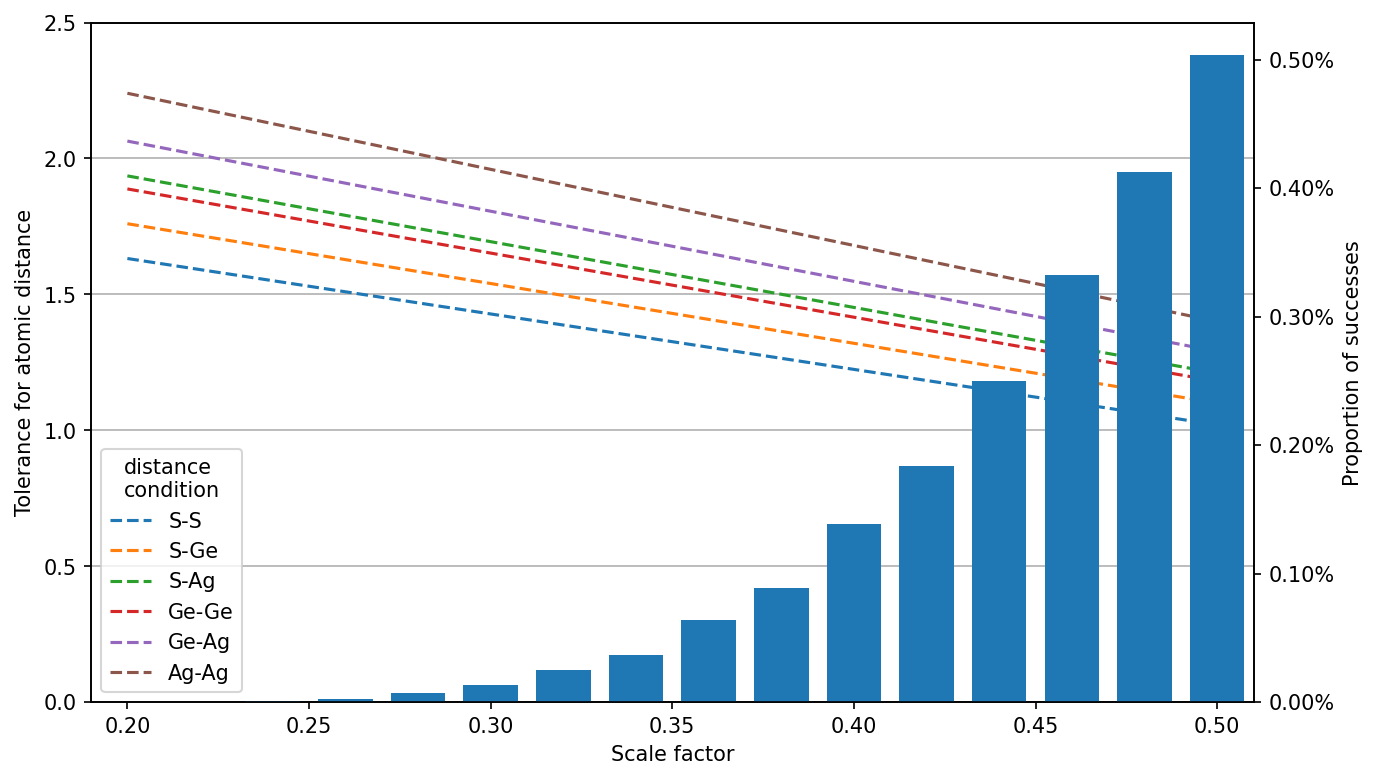

In [17]:
results = pd.DataFrame(results, columns=['scale', 'proportion', 'S-S', 'S-Ge', 'S-Ag', 'Ge-Ge', 'Ge-Ag', 'Ag-Ag'])
f, ax_tolerance = plt.subplots(figsize=(10, 6), dpi=150)

results.plot.line(x='scale', y=['S-S', 'S-Ge', 'S-Ag', 'Ge-Ge', 'Ge-Ag', 'Ag-Ag'], linestyle='dashed', ax=ax_tolerance)
ax_tolerance.set_ylim(0, 2.5)
ax_tolerance.set_ylabel('Tolerance for atomic distance')
ax_tolerance.set_xlabel('Scale factor')
ax_tolerance.legend(loc='lower left', title='distance\ncondition')
ax_tolerance.grid(axis='y')
ax_tolerance.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax_size= ax_tolerance.twinx()
ax_size.bar(results.scale, results.proportion, 0.015)
ax_size.yaxis.set_major_formatter(PercentFormatter(1))
ax_size.set_ylabel('Proportion of successes')
ax_size.set_xlim(0.19, 0.51)

# f.savefig('Ag32Ge4S24_generation_analysis.png', bbox_inches='tight', dpi=300)

Structure generation use empirical coordinates

In [63]:
ss_ = cg.gen_one(S=['a'] * 15, check_distance=False)
ss_ = build_structure(ss_,)

In [69]:
ss_['structure'].to('cif', filename='test.cif', symprec=0.01)

In [48]:
t_ = get_equivalent_coords(ss['structure'])

In [64]:
set([str(s) for s in ss_['structure'].frac_coords]) == set([str(s) for s in ss[0].frac_coords])

True